# IMPORT DATA



The purpose of this notebook is to create a prediction model, which takes into account the metadata about patient and the samples as the ECG curves. Targets for the model will be superclasses as defined by the dataset.

Superclasses enumerated by dataset description are as follows:
```
Records | Superclass | Description
9528 | NORM | Normal ECG
5486 | MI | Myocardial Infarction
5250 | STTC | ST/T Change
4907 | CD | Conduction Disturbance
2655 | HYP | Hypertrophy
```

In [1]:
import os
import ast
import wfdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as keras

sns.set_style('darkgrid')

In [2]:
PATH_TO_DATA = '../ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'

ECG_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'ptbxl_database.csv'), index_col='ecg_id')
ECG_df.scp_codes = ECG_df.scp_codes.apply(lambda x: ast.literal_eval(x))
ECG_df.patient_id = ECG_df.patient_id.astype(int)
ECG_df.nurse = ECG_df.nurse.astype('Int64')
ECG_df.site = ECG_df.site.astype('Int64')
ECG_df.validated_by = ECG_df.validated_by.astype('Int64')

SCP_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'scp_statements.csv'), index_col=0)
SCP_df = SCP_df[SCP_df.diagnostic == 1]

half_rows = len(ECG_df) // 2
ECG_df = ECG_df.iloc[half_rows:]
ECG_df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
10919,20855,74.0,0,NaN,NaN,1,2,CS-12,1993-09-04 12:09:33,vorhofflimmern/-flattern linkstyp linksschenke...,...,True,", V3",", alles,",NaN,NaN,1ES,NaN,9,records100/10000/10919_lr,records500/10000/10919_hr
10920,891,61.0,0,190.0,95.0,8,1,AT-6 C 5.5,1993-09-04 13:05:05,sinus rhythm. normal ecg.,...,True,NaN,NaN,NaN,NaN,NaN,NaN,1,records100/10000/10920_lr,records500/10000/10920_hr
10921,5577,70.0,1,170.0,77.0,3,1,AT-6 C 5.5,1993-09-04 13:07:21,sinus rhythm. prolonged pr interval. r-s trans...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,1,records100/10000/10921_lr,records500/10000/10921_hr
10922,14293,45.0,0,NaN,NaN,0,0,CS100 3,1993-09-04 13:20:28,sinusrhythmus linkstyp unspezifischer intraven...,...,False,NaN,NaN,NaN,NaN,NaN,NaN,8,records100/10000/10922_lr,records500/10000/10922_hr
10923,5849,74.0,0,178.0,71.0,4,1,AT-6 C 5.5,1993-09-04 13:36:57,sinus rhythm. no definite pathology.,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/10000/10923_lr,records500/10000/10923_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180,67.0,1,NaN,NaN,1,2,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703,93.0,0,NaN,NaN,1,2,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311,59.0,1,NaN,NaN,1,2,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


In [3]:
def diagnostic_class(scp):
    res = set()
    for k in scp.keys():
        if k in SCP_df.index:
            res.add(SCP_df.loc[k].diagnostic_class)
    return list(res)
                    
ECG_df['scp_classes'] = ECG_df.scp_codes.apply(diagnostic_class)

In [4]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

sampling_rate = 100

ECG_data = load_raw_data(ECG_df, sampling_rate, PATH_TO_DATA)

ECG_data.shape

(10919, 1000, 12)

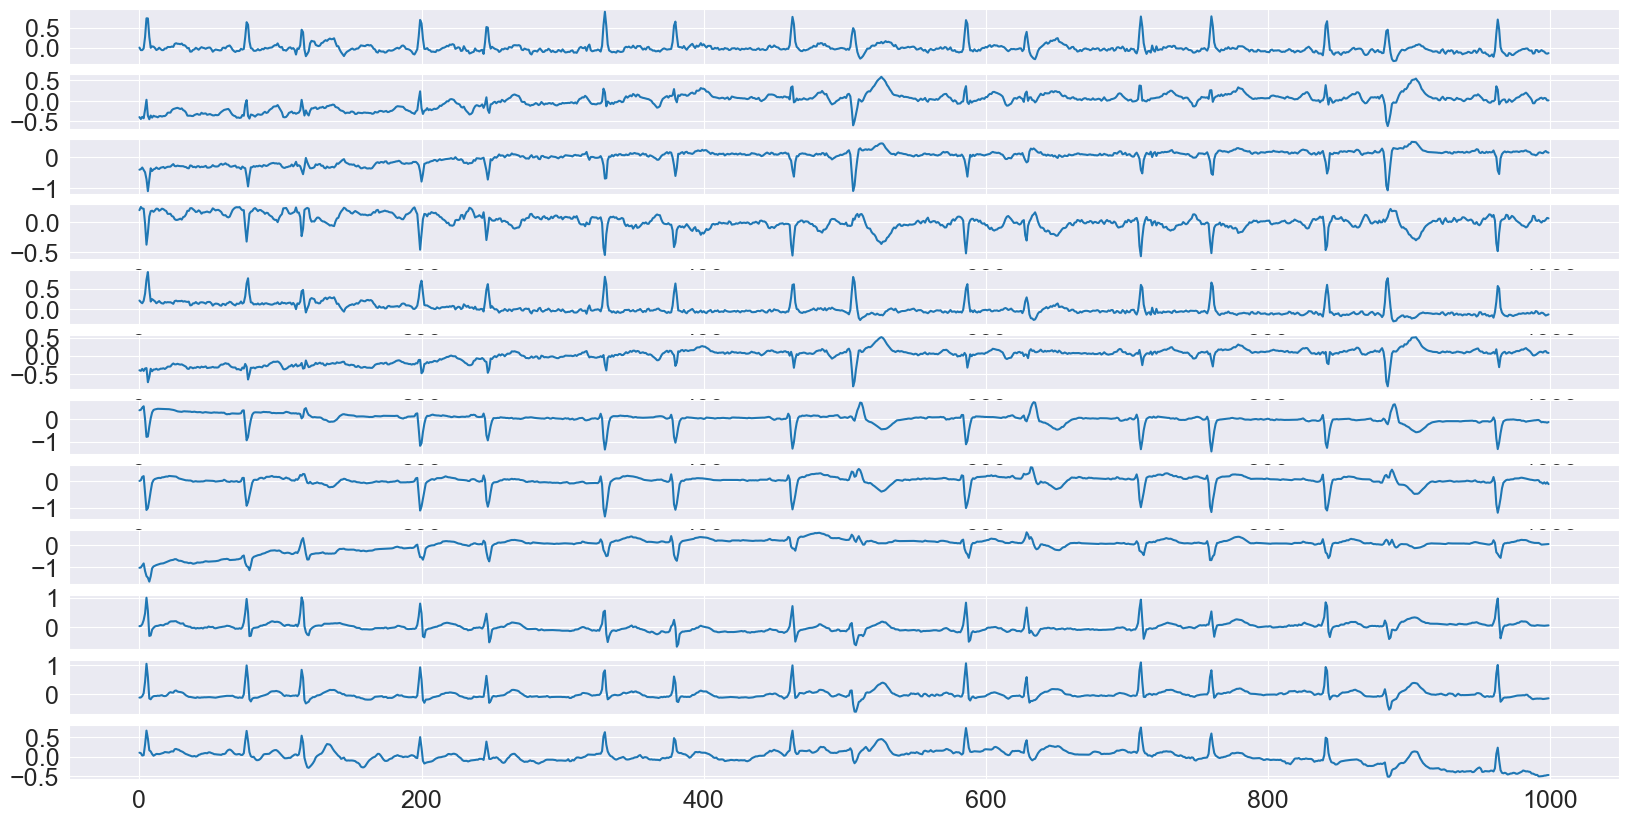

In [5]:
sample = ECG_data[0]  # Pastikan ECG_data sudah ada dalam lingkungan Anda
bar, axes = plt.subplots(sample.shape[1], 1, figsize=(20, 10))

for i in range(sample.shape[1]):
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])

# Perbesar angka pada sumbu X dan Y
for ax in axes:
    ax.tick_params(axis='both', labelsize=18)  # Mengatur ukuran font untuk sumbu X dan Y

plt.show()

In [6]:
ECG_df[[col for col in ECG_df.columns if col not in ('scp_codes', 'scp_classes')]].nunique(dropna=True)

patient_id                       9228
age                                90
sex                                 2
height                             63
weight                            107
nurse                              12
site                               49
device                             11
recording_date                  10908
report                           5312
heart_axis                          8
infarction_stadium1                 6
infarction_stadium2                 3
validated_by                       12
second_opinion                      2
initial_autogenerated_report        2
validated_by_human                  2
baseline_drift                    182
static_noise                       90
burst_noise                        73
electrodes_problems                 6
extra_beats                       100
pacemaker                           2
strat_fold                         10
filename_lr                     10919
filename_hr                     10919
dtype: int64

# Data preparation for modeling

## X dataframe (metadata)

In [7]:
X = pd.DataFrame(index=ECG_df.index)

X['age'] = ECG_df.age
X.age.fillna(0, inplace=True)

X['sex'] = ECG_df.sex.astype(float)
X.sex.fillna(0, inplace=True)

X['height'] = ECG_df.height
X.loc[X.height < 50, 'height'] = np.nan
X.height.fillna(0, inplace=True)

X['weight'] = ECG_df.weight
X.weight.fillna(0, inplace=True)

X['infarction_stadium1'] = ECG_df.infarction_stadium1.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium I-II': 2,
    'Stadium II': 3,
    'Stadium II-III': 4,
    'Stadium III': 5
}).fillna(0)

X['infarction_stadium2'] = ECG_df.infarction_stadium2.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium II': 2,
    'Stadium III': 3
}).fillna(0)

X['pacemaker'] = (ECG_df.pacemaker == 'ja, pacemaker').astype(float)

X

C:\Users\oc\AppData\Local\Temp\ipykernel_3988\3316299910.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X.age.fillna(0, inplace=True)
C:\Users\oc\AppData\Local\Temp\ipykernel_3988\3316299910.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].m

,age,sex,height,weight,infarction_stadium1,infarction_stadium2,pacemaker
ecg_id,,,,,,,
10919,74.0,0.0,0.0,0.0,0.0,0.0,0.0
10920,61.0,0.0,190.0,95.0,0.0,0.0,0.0
10921,70.0,1.0,170.0,77.0,0.0,0.0,0.0
10922,45.0,0.0,0.0,0.0,0.0,0.0,0.0
10923,74.0,0.0,178.0,71.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
21833,67.0,1.0,0.0,0.0,0.0,0.0,0.0
21834,93.0,0.0,0.0,0.0,4.0,0.0,0.0
21835,59.0,1.0,0.0,0.0,0.0,0.0,0.0


## Y dataframe (raw signal)

## Z targets (target)

In [8]:
Z = pd.DataFrame(0, index=ECG_df.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    for k in ECG_df.loc[i].scp_classes:
        Z.loc[i, k] = 1

Z

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
10919,0,1,0,0,0
10920,1,0,0,0,0
10921,0,0,1,0,1
10922,0,0,0,1,0
10923,0,0,1,0,1
...,...,...,...,...,...
21833,0,0,1,0,0
21834,1,0,0,0,0
21835,0,0,1,0,0


## Splitting to train, validate and test datasets

As the authors of PTB-XL ECG dataset suggest, I will split all input and output dataset to training, validation and test subsets according *strat_fold* column.

In [9]:
from sklearn.model_selection import train_test_split
X_train, Y_train, Z_train = X[ECG_df.strat_fold <= 10],  ECG_data[X[ECG_df.strat_fold <= 10].index - 10919],  Z[ECG_df.strat_fold <= 10]
mask_train = (Z_train['NORM'] == 1) | (Z_train['MI'] == 1)
X_train_filtered = X_train[mask_train]
Y_train_filtered = Y_train[mask_train]
Z_train_filtered = Z_train[mask_train].drop(columns=['STTC', 'CD', 'HYP'])

X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(
    X_train_filtered, Y_train_filtered, Z_train_filtered, test_size=0.1, random_state=42
)
print(X_train.shape, Y_train.shape, Z_train.shape)
print(X_test.shape,  Y_test.shape,  Z_test.shape)

(6682, 7) (6682, 1000, 12) (6682, 2)
(743, 7) (743, 1000, 12) (743, 2)


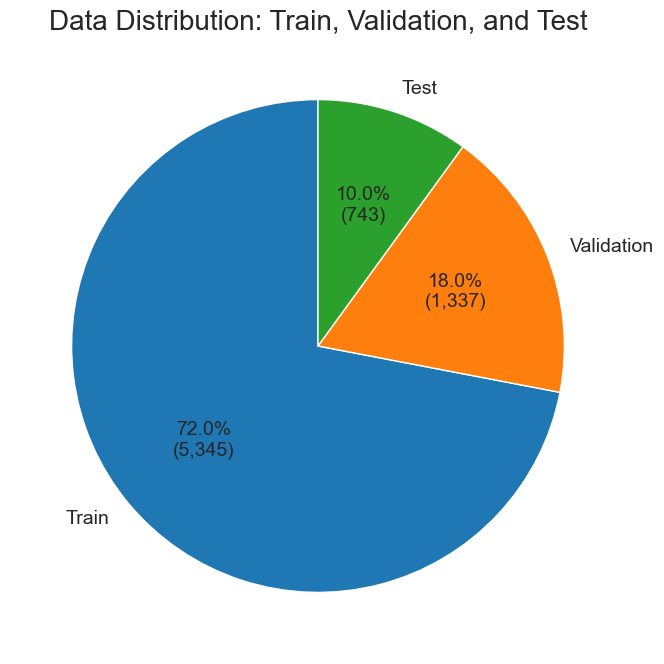

In [11]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train_dummy, X_valid_dummy, Y_train_dummy, Y_valid_dummy, Z_train_dummy, Z_valid_dummy = train_test_split(
    X_train, Y_train, Z_train, test_size=0.2, random_state=42
)

# Example data sizes (replace with actual sizes from your data)
train_size = X_train_dummy.shape[0]  # replace with X_train.shape[0]
valid_size = X_valid_dummy.shape[0]  # replace with X_valid.shape[0]
test_size = X_test.shape[0]   # replace with X_test.shape[0]

# Sizes of each dataset
sizes = [train_size, valid_size, test_size]
labels = ['Train', 'Validation', 'Test']

def autopct_with_values(pct, all_values):
    absolute = int(round(pct / 100. * sum(all_values)))
    return f"{pct:.1f}%\n({absolute:,})"

plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct=lambda pct: autopct_with_values(pct, sizes),
    startangle=90,
    textprops={'fontsize': 14}
)
plt.title('Data Distribution: Train, Validation, and Test', fontsize=20)
plt.show()

In [10]:
from sklearn.preprocessing import StandardScaler

# Step 1: Initialize the scaler
X_scaler = StandardScaler()

# Step 2: Fit the scaler only on the X_train data
X_scaler.fit(X_train)

# Step 3: Transform the training, validation, and test sets using the fitted scaler
X_train_scaled = pd.DataFrame(X_scaler.transform(X_train), columns=X_train.columns)
X_test_scaled  = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns)

# Check the shapes to ensure everything is scaled correctly
print("Scaled Train shape:", X_train_scaled.shape)
print("Scaled Test shape:", X_test_scaled.shape)

Scaled Train shape: (6682, 7)
Scaled Test shape: (743, 7)


In [14]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler for Y data
Y_scaler = StandardScaler()

# Step 1: Fit the scaler only on the Y_train data
Y_scaler.fit(Y_train.reshape(-1, Y_train.shape[-1]))

# Step 2: Transform the training, validation, and test sets
Y_train_scaled = Y_scaler.transform(Y_train.reshape(-1, Y_train.shape[-1])).reshape(Y_train.shape)
Y_test_scaled  = Y_scaler.transform(Y_test.reshape(-1, Y_test.shape[-1])).reshape(Y_test.shape)

# Check the shapes to ensure everything is scaled correctly
print("Scaled Train Y shape:", Y_train_scaled.shape)
print("Scaled Test Y shape:", Y_test_scaled.shape)


Scaled Train Y shape: (6682, 1000, 12)
Scaled Test Y shape: (743, 1000, 12)


In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Prepare data
# Ensure the input is 3D (samples, timesteps, features) for LSTM

X_train = Y_train_scaled  # Using the signal data as X
X_test  = Y_test_scaled

# Z is the target (NORM, MI)
y_train = Z_train[['NORM', 'MI']].values
y_test  = Z_test[['NORM', 'MI']].values




In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adam

# Membuat objek StratifiedKFold dengan 5 fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Variabel untuk menyimpan hasil fold
folds = []

# Melakukan pembagian data ke dalam 5 fold
for train_index, val_index in kf.split(X_train, np.argmax(y_train, axis=1)):  # Pastikan menggunakan y_train, bukan y_test
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Menyimpan fold hasil pemisahan
    folds.append((X_train_fold, X_val_fold, y_train_fold, y_val_fold))

    # Anda bisa melakukan pelatihan model atau evaluasi pada tiap fold disini
    # Misalnya:
    # model.fit(X_train_fold, y_train_fold)
    # model.score(X_val_fold, y_val_fold)

# Output folds (sebagai contoh)
for i, (X_train_fold, X_val_fold, y_train_fold, y_val_fold) in enumerate(folds):
    print(f"Fold {i+1}:")
    print(f"X_train_fold shape: {X_train_fold.shape}, y_train_fold shape: {y_train_fold.shape}")
    print(f"X_val_fold shape: {X_val_fold.shape}, y_val_fold shape: {y_val_fold.shape}")
    print("="*50)

Fold 1:
X_train_fold shape: (5345, 1000, 12), y_train_fold shape: (5345, 2)
X_val_fold shape: (1337, 1000, 12), y_val_fold shape: (1337, 2)
Fold 2:
X_train_fold shape: (5345, 1000, 12), y_train_fold shape: (5345, 2)
X_val_fold shape: (1337, 1000, 12), y_val_fold shape: (1337, 2)
Fold 3:
X_train_fold shape: (5346, 1000, 12), y_train_fold shape: (5346, 2)
X_val_fold shape: (1336, 1000, 12), y_val_fold shape: (1336, 2)
Fold 4:
X_train_fold shape: (5346, 1000, 12), y_train_fold shape: (5346, 2)
X_val_fold shape: (1336, 1000, 12), y_val_fold shape: (1336, 2)
Fold 5:
X_train_fold shape: (5346, 1000, 12), y_train_fold shape: (5346, 2)
X_val_fold shape: (1336, 1000, 12), y_val_fold shape: (1336, 2)


In [17]:
from tensorflow.keras.models import load_model
# Path to your model files
lstm_model_path = '../pretrained_algo/modelResult/final_lstm_model.h5'
stacked_lstm_model_path = '../pretrained_algo/modelResult/final_stacked_lstm_model.h5'
bi_lstm_model_path = '../pretrained_algo/modelResult/final_bi_lstm_model.h5'

# LSTM

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,300 (55.86 KB)

 Trainable params: 14,298 (55.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)


Processing Fold 1



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8261 - loss: 0.4505
Epoch 1: val_accuracy improved from -inf to 0.83321, saving model to modelResult/best_lstm_model_fold_1.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - accuracy: 0.8261 - loss: 0.4505 - val_accuracy: 0.8332 - val_loss: 0.4152 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8554 - loss: 0.3682
Epoch 2: val_accuracy improved from 0.83321 to 0.84966, saving model to modelResult/best_lstm_model_fold_1.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 40s 121ms/step - accuracy: 0.8554 - loss: 0.3682 - val_accuracy: 0.8497 - val_loss: 0.3692 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8581 - loss: 0.3624
Epoch 3: val_accuracy improved from 0.84966 to 0.85116, saving model to modelResult/best_lstm_model_fold_1.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - accuracy: 0.8581 - loss: 0.3624 - val_accuracy: 0.8512 - val_loss:

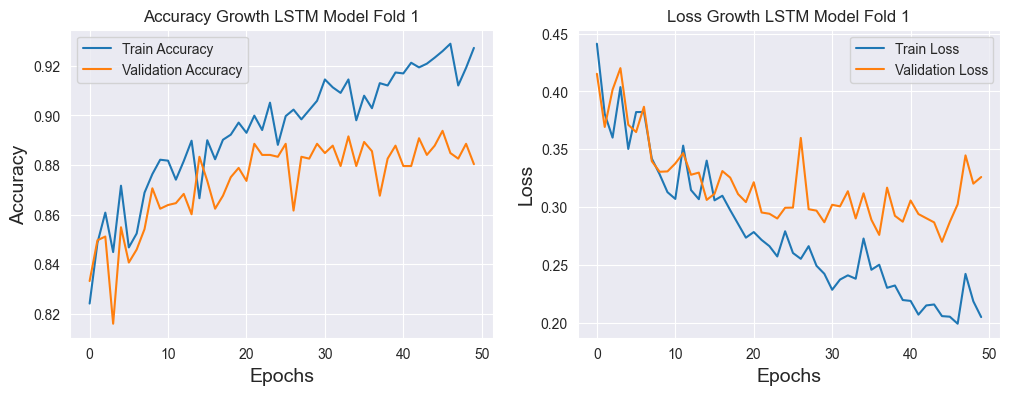

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8886 - loss: 0.2758
Test Loss: 0.27846911549568176, Test Accuracy: 0.88559889793396
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step


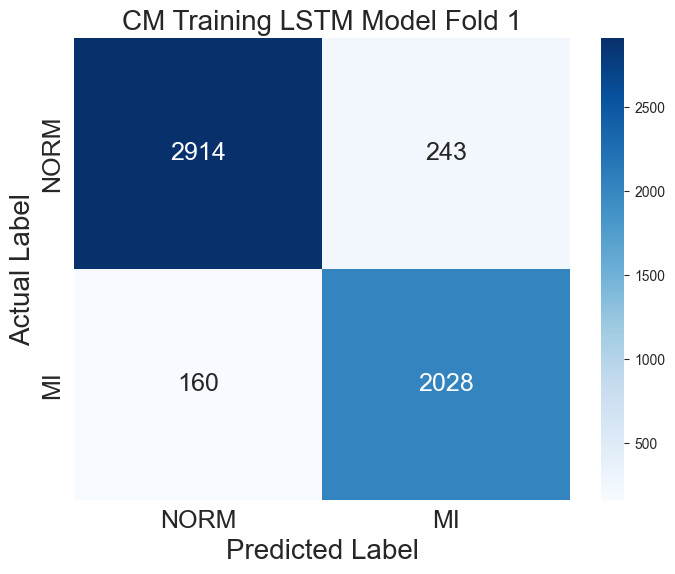

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


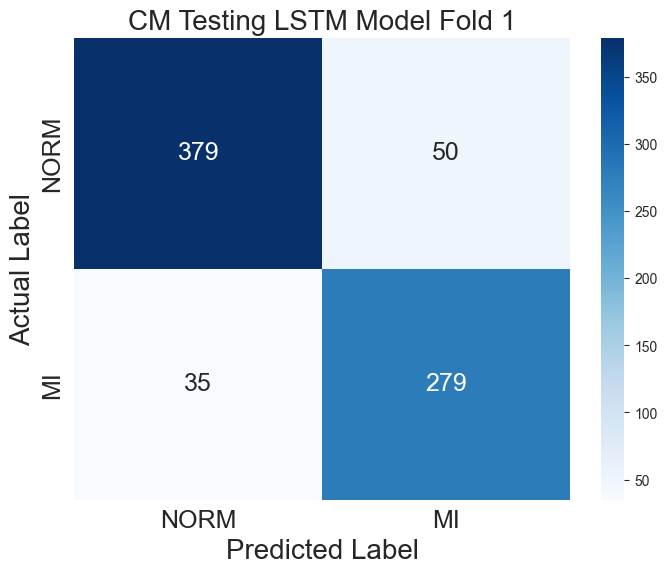


Processing Fold 2



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8119 - loss: 0.4888
Epoch 1: val_accuracy improved from -inf to 0.84892, saving model to modelResult/best_lstm_model_fold_2.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 44s 126ms/step - accuracy: 0.8119 - loss: 0.4887 - val_accuracy: 0.8489 - val_loss: 0.3954 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8069 - loss: 0.4445
Epoch 2: val_accuracy did not improve from 0.84892
335/335 ━━━━━━━━━━━━━━━━━━━━ 42s 124ms/step - accuracy: 0.8069 - loss: 0.4445 - val_accuracy: 0.8018 - val_loss: 0.4172 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8031 - loss: 0.4300
Epoch 3: val_accuracy did not improve from 0.84892
335/335 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - accuracy: 0.8031 - loss: 0.4300 - val_accuracy: 0.8100 - val_loss: 0.4289 - learning_rate: 0.0010
Epoch 4/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7612 - loss: 0.4715
Epoc

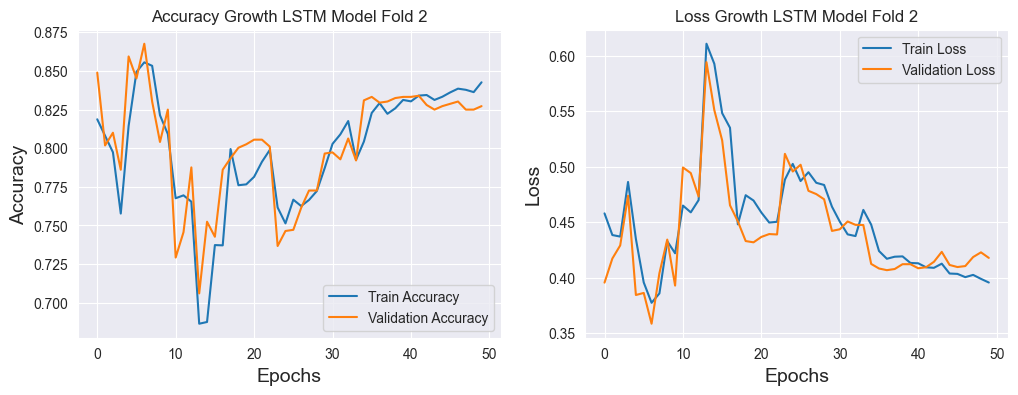

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8209 - loss: 0.4107
Test Loss: 0.41308093070983887, Test Accuracy: 0.8196500539779663
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step


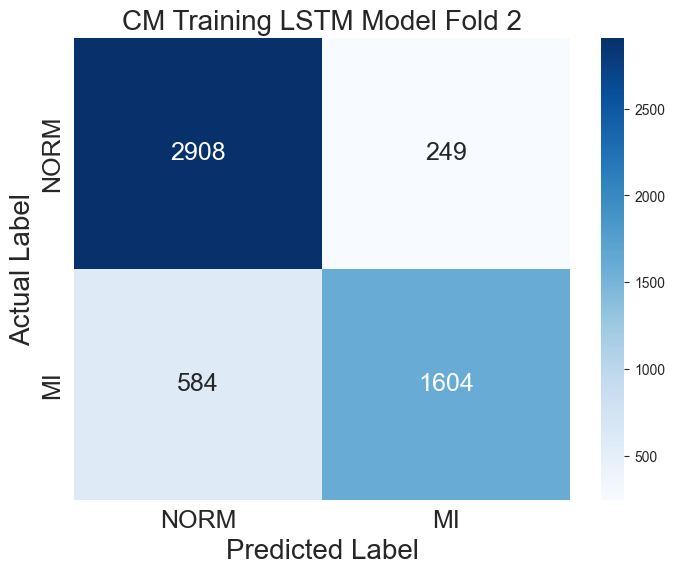

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


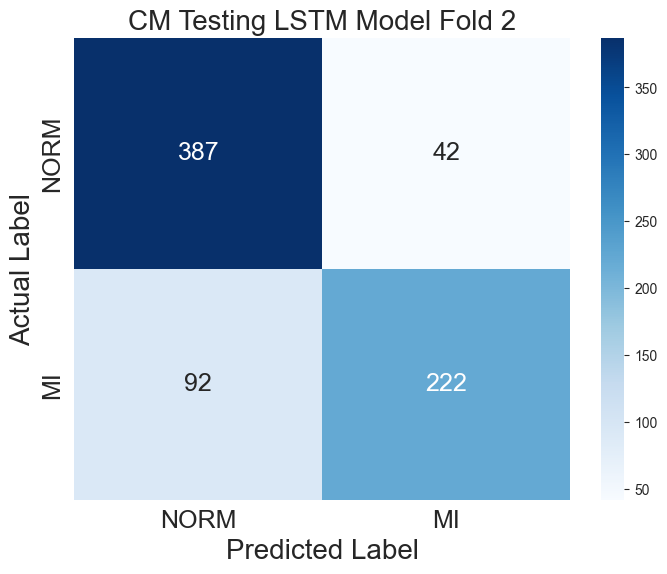


Processing Fold 3



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8050 - loss: 0.4675
Epoch 1: val_accuracy improved from -inf to 0.83308, saving model to modelResult/best_lstm_model_fold_3.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 44s 129ms/step - accuracy: 0.8050 - loss: 0.4675 - val_accuracy: 0.8331 - val_loss: 0.4493 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8157 - loss: 0.4338
Epoch 2: val_accuracy improved from 0.83308 to 0.83533, saving model to modelResult/best_lstm_model_fold_3.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 41s 124ms/step - accuracy: 0.8156 - loss: 0.4338 - val_accuracy: 0.8353 - val_loss: 0.4221 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8177 - loss: 0.4207
Epoch 3: val_accuracy did not improve from 0.83533
335/335 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.8177 - loss: 0.4207 - val_accuracy: 0.8226 - val_loss: 0.4078 - learning_rate: 0.0010
Epoch 4/50
335/335 ━━━━━━━━━━━

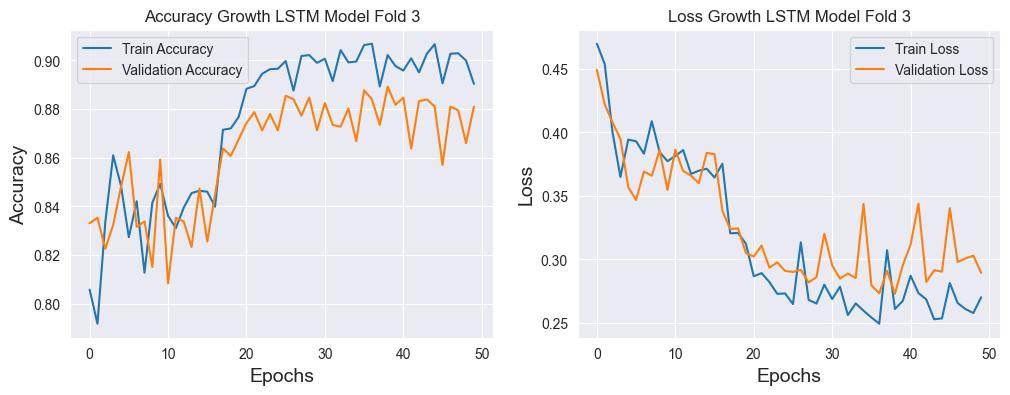

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8864 - loss: 0.2845
Test Loss: 0.2872432470321655, Test Accuracy: 0.8869448304176331
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step


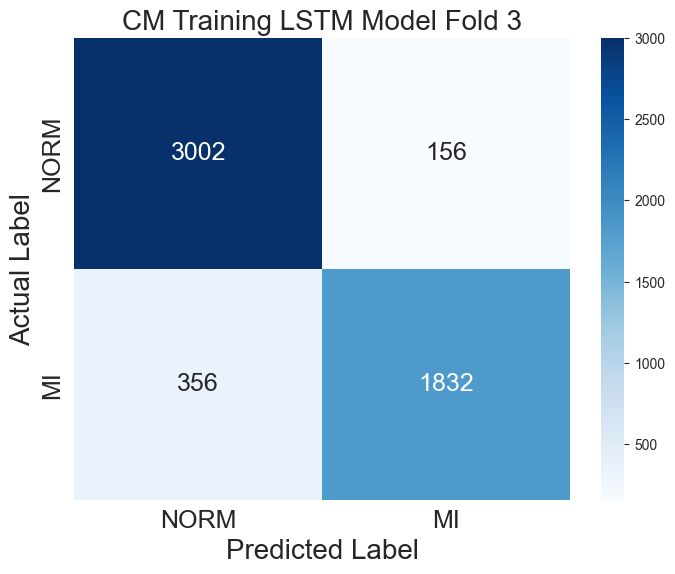

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


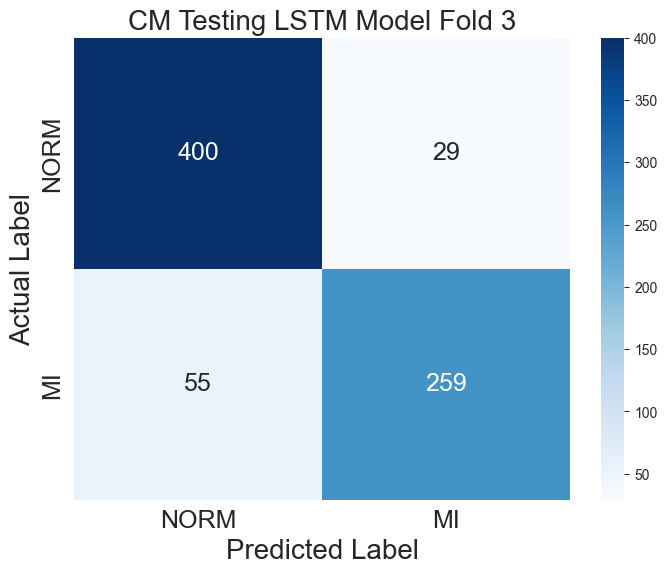


Processing Fold 4



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8226 - loss: 0.4491
Epoch 1: val_accuracy improved from -inf to 0.84057, saving model to modelResult/best_lstm_model_fold_4.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 43s 126ms/step - accuracy: 0.8226 - loss: 0.4492 - val_accuracy: 0.8406 - val_loss: 0.3849 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8314 - loss: 0.4189
Epoch 2: val_accuracy did not improve from 0.84057
335/335 ━━━━━━━━━━━━━━━━━━━━ 41s 124ms/step - accuracy: 0.8313 - loss: 0.4189 - val_accuracy: 0.8211 - val_loss: 0.4158 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8186 - loss: 0.4268
Epoch 3: val_accuracy did not improve from 0.84057
335/335 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - accuracy: 0.8186 - loss: 0.4268 - val_accuracy: 0.8031 - val_loss: 0.4268 - learning_rate: 0.0010
Epoch 4/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8145 - loss: 0.4224
Epoc

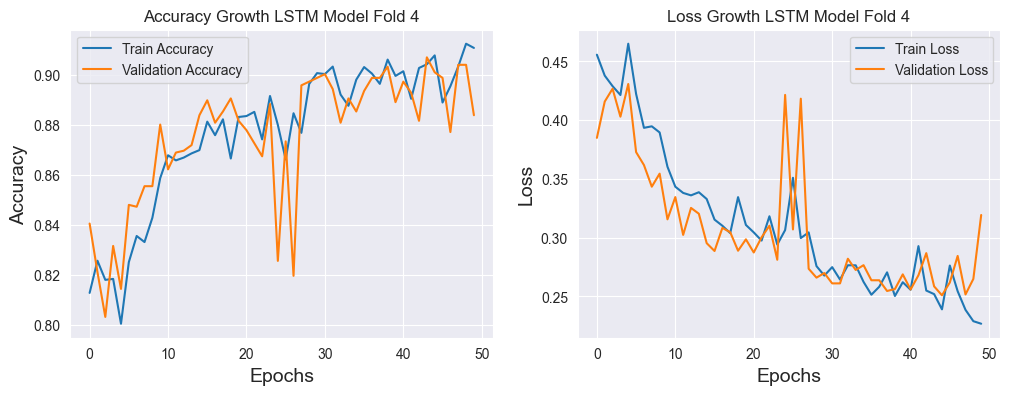

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8837 - loss: 0.3155
Test Loss: 0.3024192750453949, Test Accuracy: 0.8802153468132019
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step


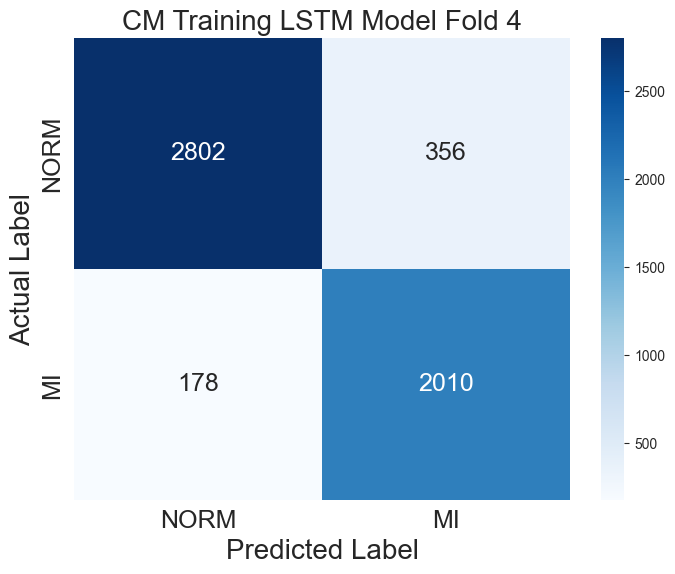

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


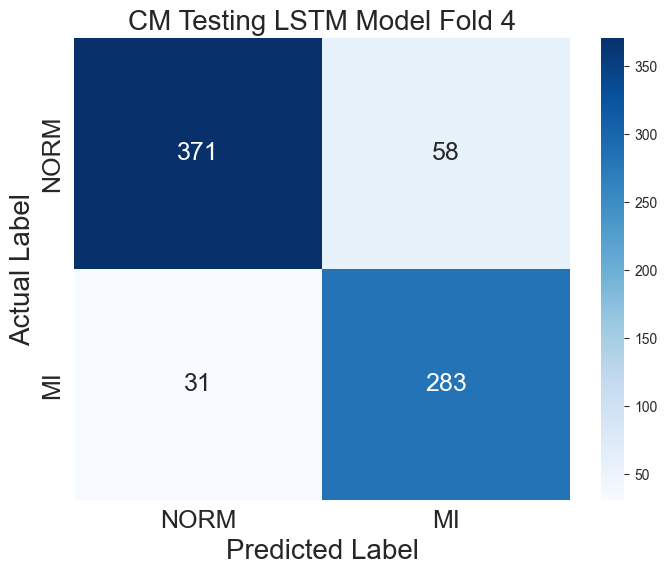


Processing Fold 5



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8078 - loss: 0.4859
Epoch 1: val_accuracy improved from -inf to 0.83683, saving model to modelResult/best_lstm_model_fold_5.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - accuracy: 0.8078 - loss: 0.4859 - val_accuracy: 0.8368 - val_loss: 0.4096 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8363 - loss: 0.4163
Epoch 2: val_accuracy improved from 0.83683 to 0.85928, saving model to modelResult/best_lstm_model_fold_5.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - accuracy: 0.8363 - loss: 0.4163 - val_accuracy: 0.8593 - val_loss: 0.3717 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8461 - loss: 0.4031
Epoch 3: val_accuracy improved from 0.85928 to 0.86527, saving model to modelResult/best_lstm_model_fold_5.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms/step - accuracy: 0.8461 - loss: 0.4031 - val_accuracy: 0.8653 - val_loss:

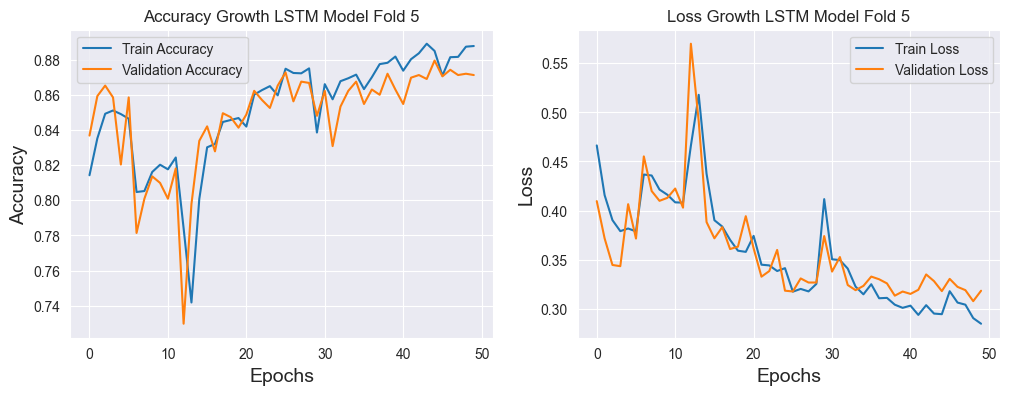

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8715 - loss: 0.3067
Test Loss: 0.3184947669506073, Test Accuracy: 0.8721399903297424
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step


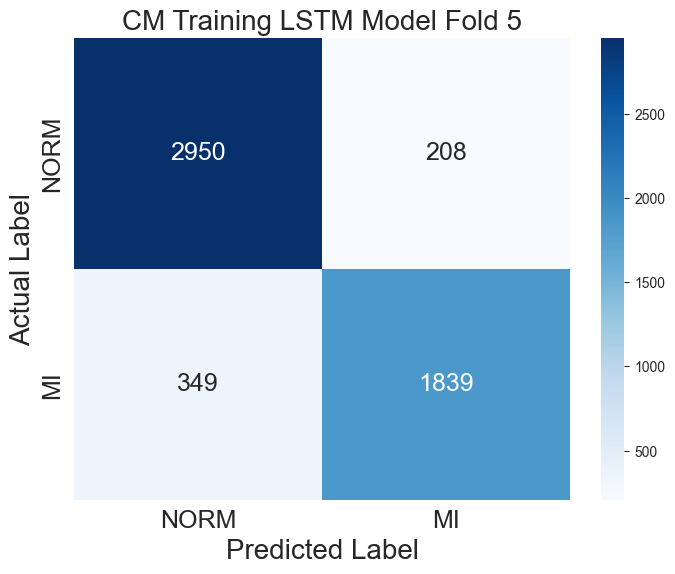

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


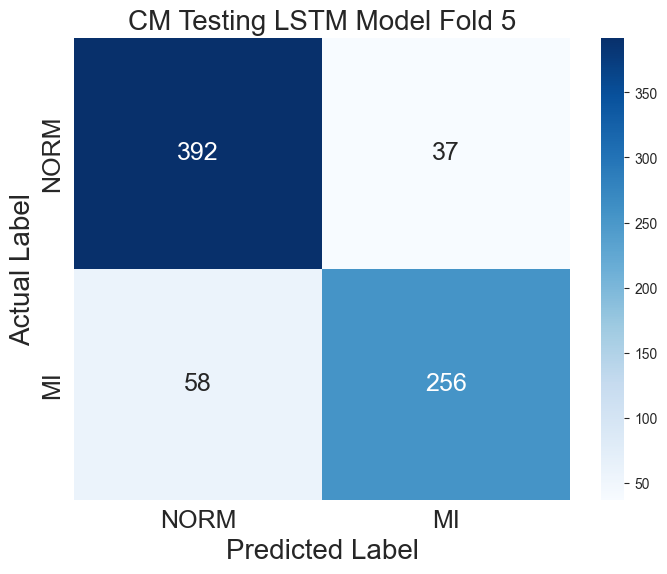


Cross-Validation Metrics Summary:
   fold  test_loss  test_accuracy
0     1   0.278469       0.885599
1     2   0.413081       0.819650
2     3   0.287243       0.886945
3     4   0.302419       0.880215
4     5   0.318495       0.872140

Average Validation Accuracy across all folds: 0.8689


In [25]:
# Placeholder untuk hasil fold
fold_metrics = []

# Step 1: Define Cross-Validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
fold = 0

# Load the pretrained LSTM model
pretrained_lstm_model = load_model(lstm_model_path)
pretrained_lstm_model.summary()

# Loop untuk setiap fold
for train_index, valid_index in kf.split(X_train, np.argmax(y_train, axis=1)):
    fold += 1
    print(f"\nProcessing Fold {fold}\n")

    # Split the data into training and validation sets for the current fold
    X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
    y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]

    # Load pre-trained model for each fold
    pretrained_lstm_model = load_model(lstm_model_path)

    pretrained_lstm_model.compile(optimizer=Adam(learning_rate=0.001), 
                                  loss='categorical_crossentropy', 
                                  metrics=['accuracy'])
    
    # Step 5: Define Callbacks
    checkpoint = ModelCheckpoint(filepath=f'modelResult/best_lstm_model_fold_{fold}.keras', 
                                 monitor='val_accuracy', 
                                 save_best_only=True, 
                                 verbose=1, 
                                 mode='max')


    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.5, 
                                  patience=10, 
                                  min_lr=0.000001, 
                                  verbose=1)

    # Step 6: Fine-tuning the new model on the current fold's training set
    history = pretrained_lstm_model.fit(X_train_fold, y_train_fold, 
                        epochs=50, 
                        batch_size=16, 
                        validation_data=(X_valid_fold, y_valid_fold),
                        callbacks=[checkpoint, reduce_lr], 
                        verbose=1)

    # Step 7: Plot accuracy and loss for the current fold
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy Growth LSTM Model Fold {fold}')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Growth LSTM Model Fold {fold}')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()

    plt.savefig(f'image/training_history_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()

    # Step 8: Evaluate model on the test set
    test_loss, test_accuracy = pretrained_lstm_model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    
    # Save fold metrics
    fold_metrics.append({
        "fold": fold,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
    })

    # Step 9: Confusion Matrix on the training set
    y_train_pred = pretrained_lstm_model.predict(X_train_fold)
    y_train_pred_classes = np.argmax(y_train_pred, axis=1)
    y_train_true_classes = np.argmax(y_train_fold, axis=1)
    
    cm_train = confusion_matrix(y_train_true_classes, y_train_pred_classes)
    labels = ['NORM', 'MI']
    
    # Plot training confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title(f'CM Training LSTM Model Fold {fold}', fontsize=20)
    plt.ylabel('Actual Label', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'image/confusion_matrix_training_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()

    # Save confusion matrix for training as CSV
    cm_train_df = pd.DataFrame(cm_train, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
    cm_train_df.to_csv(f'excel_output/confusion_matrix_training_lstm_model_fold_{fold}.csv')

    # Step 9: Confusion Matrix on the test set
    y_test_pred = pretrained_lstm_model.predict(X_test)
    y_test_pred_classes = np.argmax(y_test_pred, axis=1)
    y_test_true_classes = np.argmax(y_test, axis=1)
    
    cm_test = confusion_matrix(y_test_true_classes, y_test_pred_classes)
    labels = ['NORM', 'MI']
    
    # Plot test confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title(f'CM Testing LSTM Model Fold {fold}', fontsize=20)
    plt.ylabel('Actual Label', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'image/confusion_matrix_testing_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()

    # Save confusion matrix for testing as CSV
    cm_test_df = pd.DataFrame(cm_test, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
    cm_test_df.to_csv(f'excel_output/confusion_matrix_testing_lstm_model_fold_{fold}.csv')

# Step 10: Save the metrics summary
metrics_df = pd.DataFrame(fold_metrics)
metrics_df.to_csv('excel_output/fold_metrics_summary_lstm_model.csv', index=False)

# Print out the summary of the metrics across all folds
print("\nCross-Validation Metrics Summary:")
print(metrics_df)

# Calculate and print the average accuracy across all folds
mean_accuracy = metrics_df['test_accuracy'].mean()
print(f"\nAverage Validation Accuracy across all folds: {mean_accuracy:.4f}")


# STACKED LSTM

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 1000, 100)      │        45,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1000, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,796 (307.80 KB)

 Trainable params: 78,794 (307.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)


Processing Fold 1



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.8397 - loss: 0.3864
Epoch 1: val_accuracy improved from -inf to 0.85191, saving model to modelResult/best_stacked_lstm_model_fold_1.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 122s 352ms/step - accuracy: 0.8397 - loss: 0.3863 - val_accuracy: 0.8519 - val_loss: 0.3298 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8672 - loss: 0.3243
Epoch 2: val_accuracy improved from 0.85191 to 0.85415, saving model to modelResult/best_stacked_lstm_model_fold_1.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 122s 366ms/step - accuracy: 0.8672 - loss: 0.3242 - val_accuracy: 0.8542 - val_loss: 0.3594 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8874 - loss: 0.2948
Epoch 3: val_accuracy improved from 0.85415 to 0.86612, saving model to modelResult/best_stacked_lstm_model_fold_1.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 113s 337ms/step - accuracy: 0.8874 - loss: 0.2948 - val_a

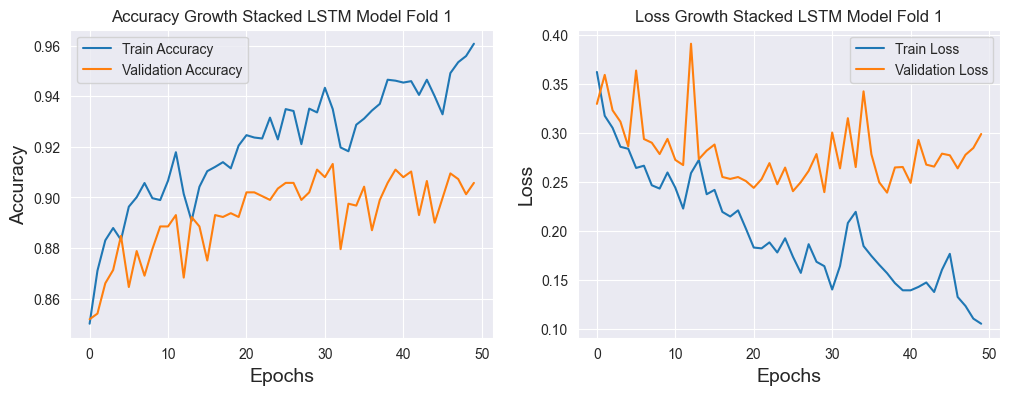

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9212 - loss: 0.2739
Test Loss: 0.26712846755981445, Test Accuracy: 0.9232839941978455
168/168 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step


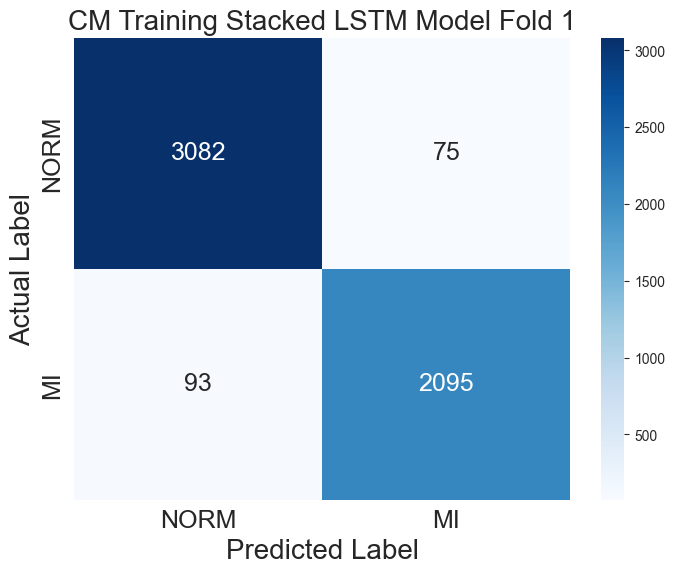

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step


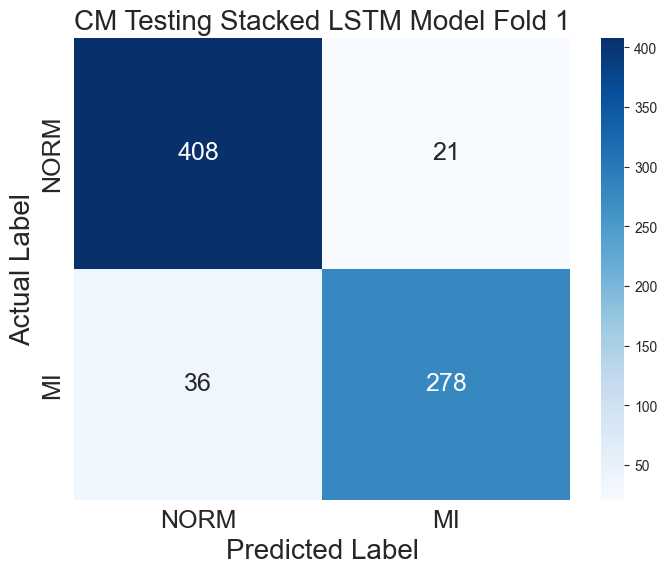


Processing Fold 2



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.8397 - loss: 0.3674
Epoch 1: val_accuracy improved from -inf to 0.86462, saving model to modelResult/best_stacked_lstm_model_fold_2.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 119s 349ms/step - accuracy: 0.8398 - loss: 0.3674 - val_accuracy: 0.8646 - val_loss: 0.3491 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.8635 - loss: 0.3632
Epoch 2: val_accuracy did not improve from 0.86462
335/335 ━━━━━━━━━━━━━━━━━━━━ 116s 346ms/step - accuracy: 0.8635 - loss: 0.3632 - val_accuracy: 0.8414 - val_loss: 0.3613 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.8706 - loss: 0.3448
Epoch 3: val_accuracy improved from 0.86462 to 0.87509, saving model to modelResult/best_stacked_lstm_model_fold_2.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 116s 347ms/step - accuracy: 0.8706 - loss: 0.3448 - val_accuracy: 0.8751 - val_loss: 0.3164 - learning_rate: 0.0010
Epoch 4/50


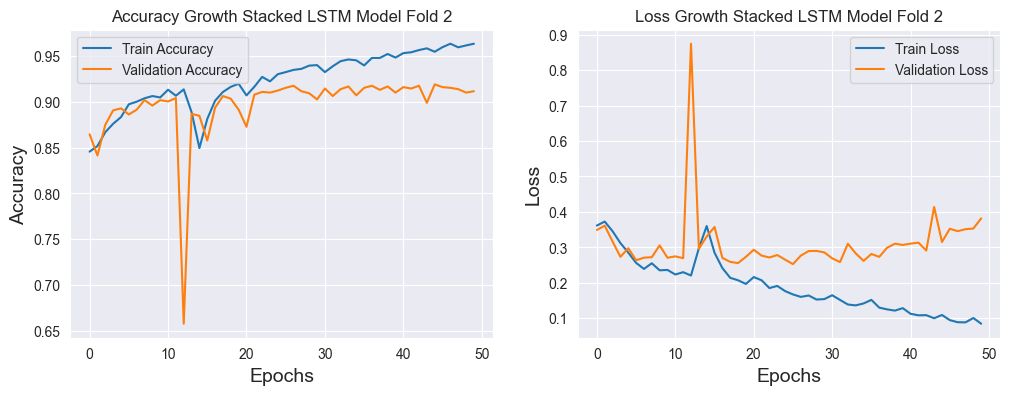

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.9131 - loss: 0.3317
Test Loss: 0.34606361389160156, Test Accuracy: 0.9192463159561157
168/168 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step


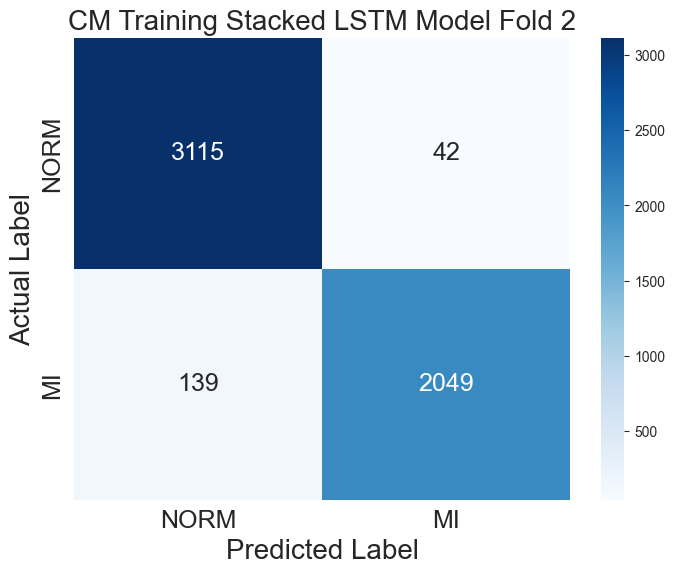

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step


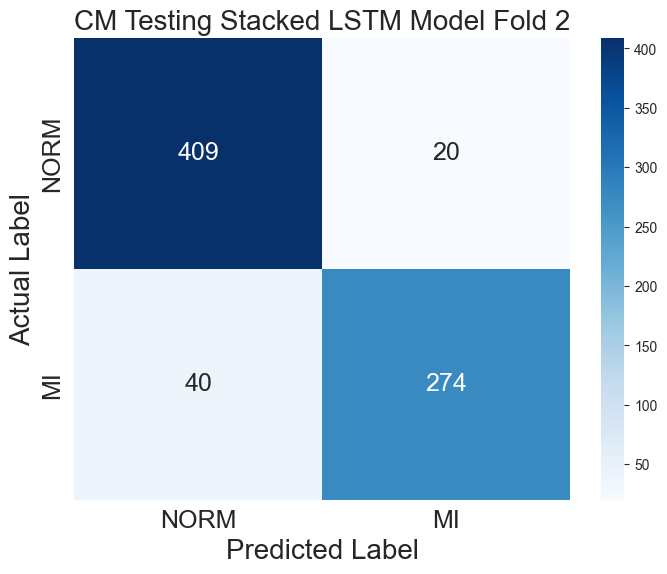


Processing Fold 3



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.8196 - loss: 0.4070
Epoch 1: val_accuracy improved from -inf to 0.85928, saving model to modelResult/best_stacked_lstm_model_fold_3.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 119s 349ms/step - accuracy: 0.8196 - loss: 0.4070 - val_accuracy: 0.8593 - val_loss: 0.3074 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.8541 - loss: 0.3394
Epoch 2: val_accuracy improved from 0.85928 to 0.88847, saving model to modelResult/best_stacked_lstm_model_fold_3.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 116s 347ms/step - accuracy: 0.8541 - loss: 0.3394 - val_accuracy: 0.8885 - val_loss: 0.2857 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.8754 - loss: 0.3080
Epoch 3: val_accuracy did not improve from 0.88847
335/335 ━━━━━━━━━━━━━━━━━━━━ 116s 345ms/step - accuracy: 0.8754 - loss: 0.3080 - val_accuracy: 0.8750 - val_loss: 0.2895 - learning_rate: 0.0010
Epoch 4/50


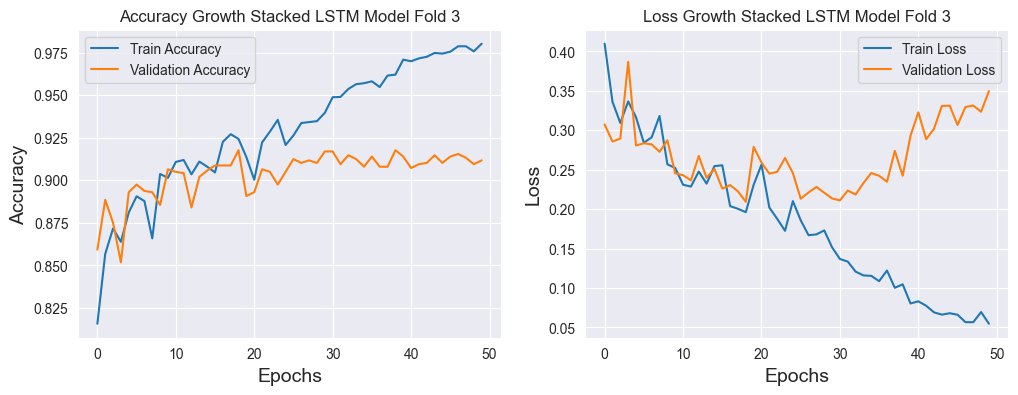

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9112 - loss: 0.3066
Test Loss: 0.34406790137290955, Test Accuracy: 0.9125168323516846
168/168 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step


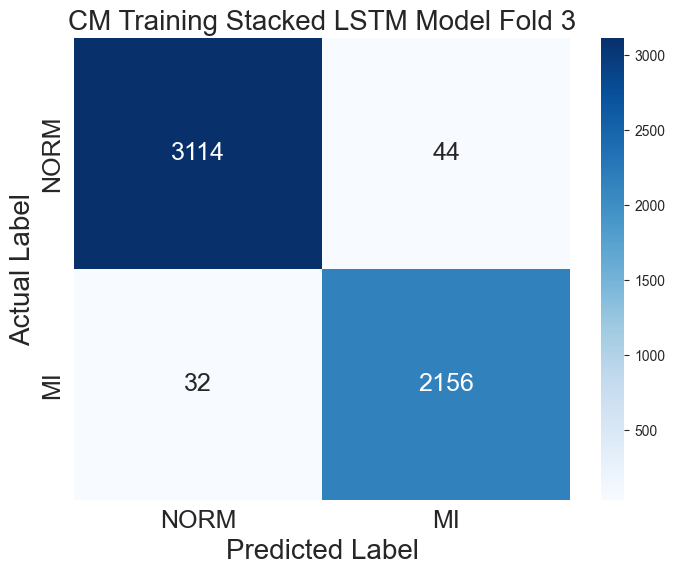

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step


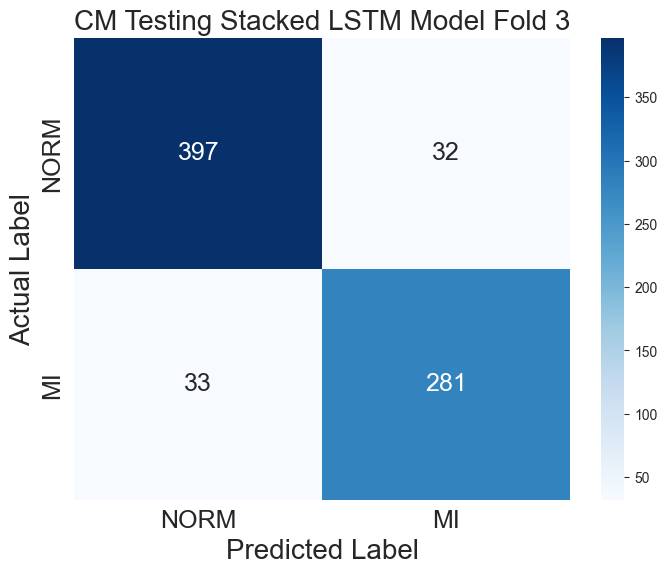


Processing Fold 4



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.8459 - loss: 0.3862
Epoch 1: val_accuracy improved from -inf to 0.88174, saving model to modelResult/best_stacked_lstm_model_fold_4.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 116s 340ms/step - accuracy: 0.8459 - loss: 0.3862 - val_accuracy: 0.8817 - val_loss: 0.3001 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.8686 - loss: 0.3251
Epoch 2: val_accuracy improved from 0.88174 to 0.88548, saving model to modelResult/best_stacked_lstm_model_fold_4.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 114s 340ms/step - accuracy: 0.8685 - loss: 0.3251 - val_accuracy: 0.8855 - val_loss: 0.2797 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.8836 - loss: 0.3125
Epoch 3: val_accuracy did not improve from 0.88548
335/335 ━━━━━━━━━━━━━━━━━━━━ 114s 340ms/step - accuracy: 0.8836 - loss: 0.3125 - val_accuracy: 0.8705 - val_loss: 0.3213 - learning_rate: 0.0010
Epoch 4/50


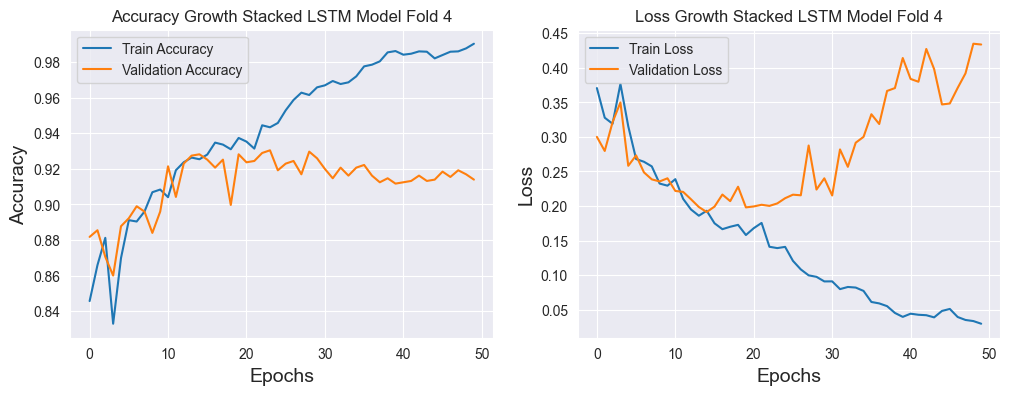

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9083 - loss: 0.5212
Test Loss: 0.4748184084892273, Test Accuracy: 0.9179003834724426
168/168 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step


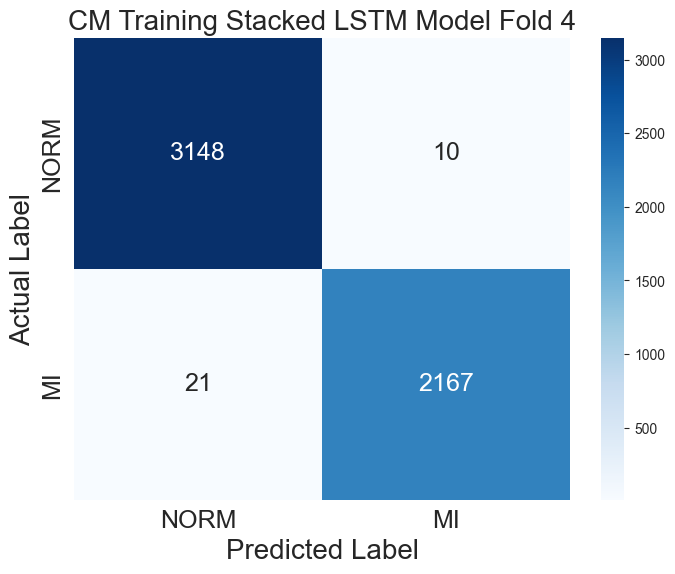

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step


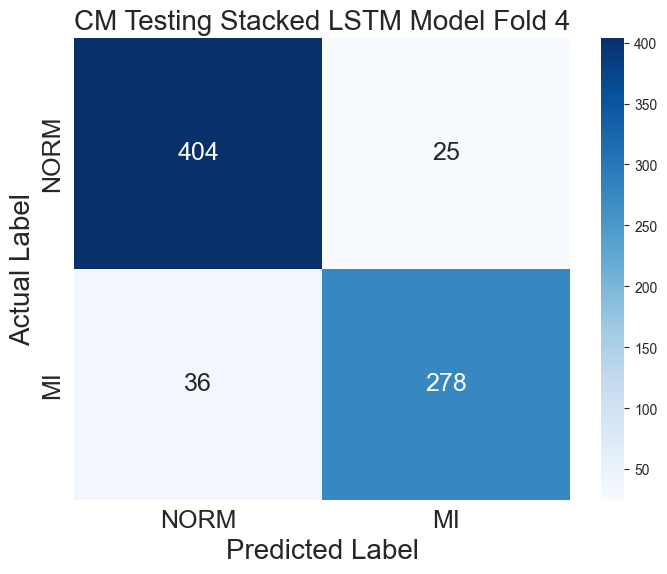


Processing Fold 5



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.8410 - loss: 0.3810
Epoch 1: val_accuracy improved from -inf to 0.84581, saving model to modelResult/best_stacked_lstm_model_fold_5.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 117s 344ms/step - accuracy: 0.8410 - loss: 0.3809 - val_accuracy: 0.8458 - val_loss: 0.3800 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.8491 - loss: 0.3695
Epoch 2: val_accuracy improved from 0.84581 to 0.88249, saving model to modelResult/best_stacked_lstm_model_fold_5.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 115s 344ms/step - accuracy: 0.8491 - loss: 0.3694 - val_accuracy: 0.8825 - val_loss: 0.3461 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.8581 - loss: 0.3680
Epoch 3: val_accuracy did not improve from 0.88249
335/335 ━━━━━━━━━━━━━━━━━━━━ 115s 343ms/step - accuracy: 0.8581 - loss: 0.3679 - val_accuracy: 0.8728 - val_loss: 0.3099 - learning_rate: 0.0010
Epoch 4/50


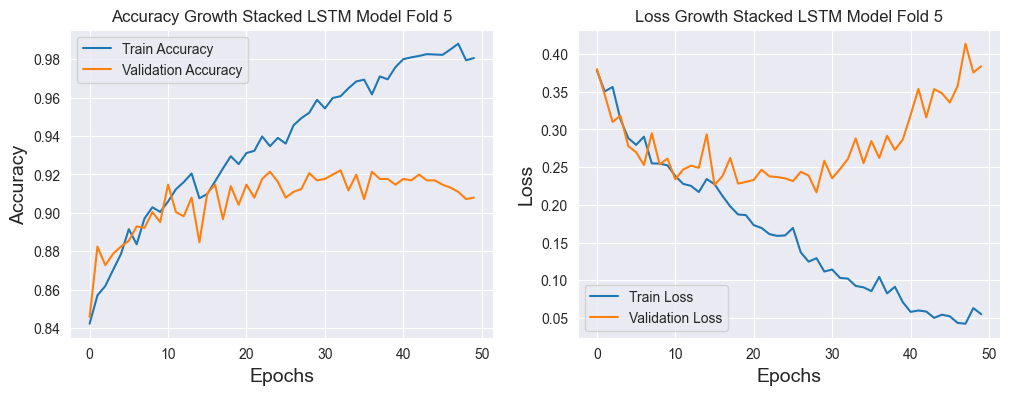

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9067 - loss: 0.4029
Test Loss: 0.3948636054992676, Test Accuracy: 0.9044414758682251
168/168 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step


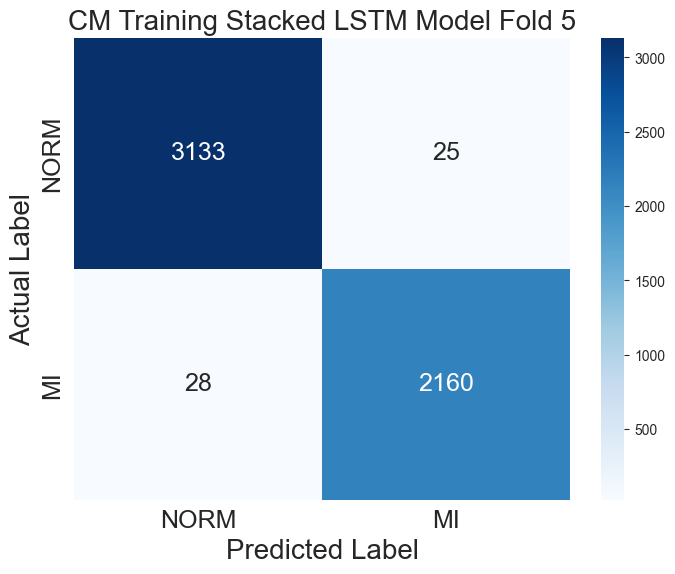

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step


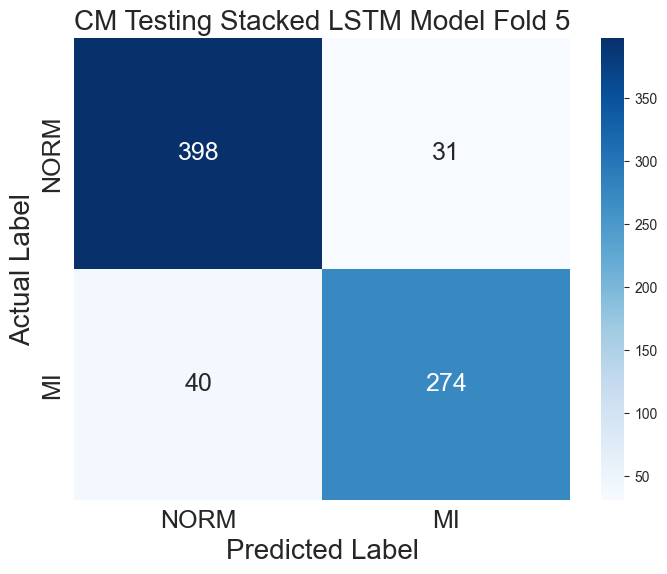


Cross-Validation Metrics Summary:
   fold  test_loss  test_accuracy
0     1   0.267128       0.923284
1     2   0.346064       0.919246
2     3   0.344068       0.912517
3     4   0.474818       0.917900
4     5   0.394864       0.904441

Average Validation Accuracy across all folds: 0.9155


In [24]:
# Placeholder untuk hasil fold
fold_metrics = []

# Step 1: Define Cross-Validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
fold = 0

# Load the pretrained Stacked LSTM model
pretrained_stacked_lstm_model = load_model(stacked_lstm_model_path)
pretrained_stacked_lstm_model.summary()

# Loop untuk setiap fold
for train_index, valid_index in kf.split(X_train, np.argmax(y_train, axis=1)):
    fold += 1
    print(f"\nProcessing Fold {fold}\n")

    # Split the data into training and validation sets for the current fold
    X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
    y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]

    # Load pre-trained model for each fold
    pretrained_stacked_lstm_model = load_model(stacked_lstm_model_path)

    pretrained_stacked_lstm_model.compile(optimizer=Adam(learning_rate=0.001), 
                                          loss='categorical_crossentropy', 
                                          metrics=['accuracy'])
    
    # Step 5: Define Callbacks
    checkpoint = ModelCheckpoint(filepath=f'modelResult/best_stacked_lstm_model_fold_{fold}.keras', 
                                 monitor='val_accuracy', 
                                 save_best_only=True, 
                                 verbose=1, 
                                 mode='max')

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.5, 
                                  patience=10, 
                                  min_lr=0.000001, 
                                  verbose=1)

    # Step 6: Fine-tuning the new model on the current fold's training set
    history = pretrained_stacked_lstm_model.fit(X_train_fold, y_train_fold, 
                        epochs=50, 
                        batch_size=16, 
                        validation_data=(X_valid_fold, y_valid_fold),
                        callbacks=[checkpoint, reduce_lr], 
                        verbose=1)

    # Step 7: Plot accuracy and loss for the current fold
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy Growth Stacked LSTM Model Fold {fold}')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Growth Stacked LSTM Model Fold {fold}')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()

    plt.savefig(f'image/training_history_stacked_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()

    # Step 8: Evaluate model on the test set
    test_loss, test_accuracy = pretrained_stacked_lstm_model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    
    # Save fold metrics
    fold_metrics.append({
        "fold": fold,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
    })

    # Step 9: Confusion Matrix on the training set
    y_train_pred = pretrained_stacked_lstm_model.predict(X_train_fold)
    y_train_pred_classes = np.argmax(y_train_pred, axis=1)
    y_train_true_classes = np.argmax(y_train_fold, axis=1)
    
    cm_train = confusion_matrix(y_train_true_classes, y_train_pred_classes)
    labels = ['NORM', 'MI']
    
    # Plot training confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title(f'CM Training Stacked LSTM Model Fold {fold}', fontsize=20)
    plt.ylabel('Actual Label', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'image/confusion_matrix_training_stacked_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()

    # Save confusion matrix for training as CSV
    cm_train_df = pd.DataFrame(cm_train, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
    cm_train_df.to_csv(f'excel_output/confusion_matrix_training_stacked_lstm_model_fold_{fold}.csv')

    # Step 9: Confusion Matrix on the test set
    y_test_pred = pretrained_stacked_lstm_model.predict(X_test)
    y_test_pred_classes = np.argmax(y_test_pred, axis=1)
    y_test_true_classes = np.argmax(y_test, axis=1)
    
    cm_test = confusion_matrix(y_test_true_classes, y_test_pred_classes)
    labels = ['NORM', 'MI']
    
    # Plot test confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title(f'CM Testing Stacked LSTM Model Fold {fold}', fontsize=20)
    plt.ylabel('Actual Label', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'image/confusion_matrix_testing_stacked_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()

    # Save confusion matrix for testing as CSV
    cm_test_df = pd.DataFrame(cm_test, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
    cm_test_df.to_csv(f'excel_output/confusion_matrix_testing_stacked_lstm_model_fold_{fold}.csv')

# Step 10: Save the metrics summary
metrics_df = pd.DataFrame(fold_metrics)
metrics_df.to_csv('excel_output/fold_metrics_summary_stacked_lstm_model.csv', index=False)

# Print out the summary of the metrics across all folds
print("\nCross-Validation Metrics Summary:")
print(metrics_df)

# Calculate and print the average accuracy across all folds
mean_accuracy = metrics_df['test_accuracy'].mean()
print(f"\nAverage Validation Accuracy across all folds: {mean_accuracy:.4f}")


# BI LSTM

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1000, 200)      │        90,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1000, 200)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,396 (771.08 KB)

 Trainable params: 197,394 (771.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)


Processing Fold 1



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8099 - loss: 0.4590
Epoch 1: val_accuracy improved from -inf to 0.83171, saving model to modelResult/best_bi_lstm_model_fold_1.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 152s 444ms/step - accuracy: 0.8099 - loss: 0.4588 - val_accuracy: 0.8317 - val_loss: 0.3978 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8306 - loss: 0.4033
Epoch 2: val_accuracy did not improve from 0.83171
335/335 ━━━━━━━━━━━━━━━━━━━━ 149s 445ms/step - accuracy: 0.8305 - loss: 0.4033 - val_accuracy: 0.7936 - val_loss: 0.4580 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8043 - loss: 0.4468
Epoch 3: val_accuracy did not improve from 0.83171
335/335 ━━━━━━━━━━━━━━━━━━━━ 149s 444ms/step - accuracy: 0.8043 - loss: 0.4467 - val_accuracy: 0.8190 - val_loss: 0.4179 - learning_rate: 0.0010
Epoch 4/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8307 - loss: 0.401

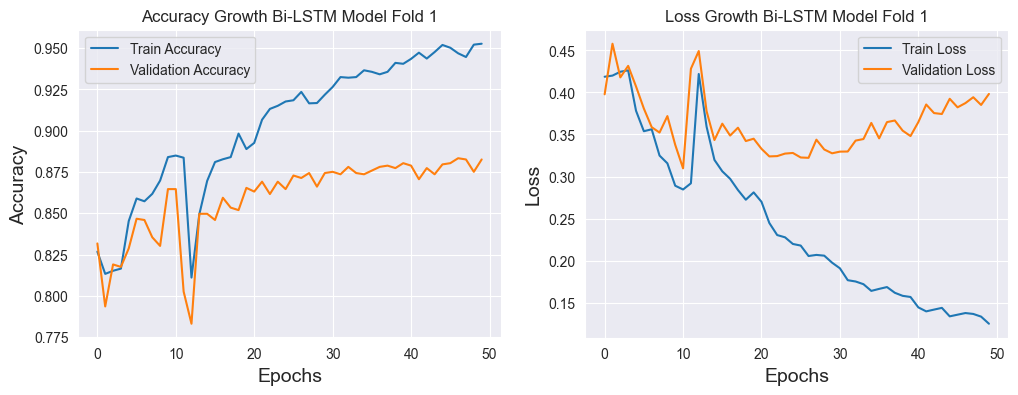

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.8814 - loss: 0.3711
Test Loss: 0.3414086401462555, Test Accuracy: 0.8936743140220642
168/168 ━━━━━━━━━━━━━━━━━━━━ 31s 182ms/step


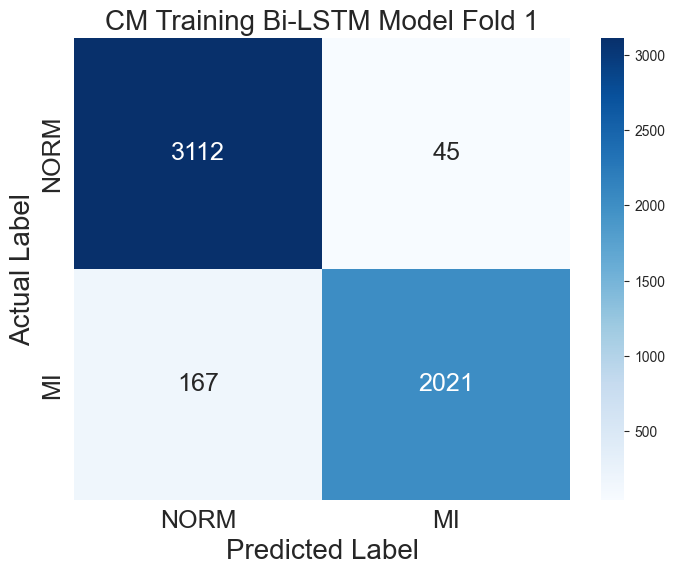

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step


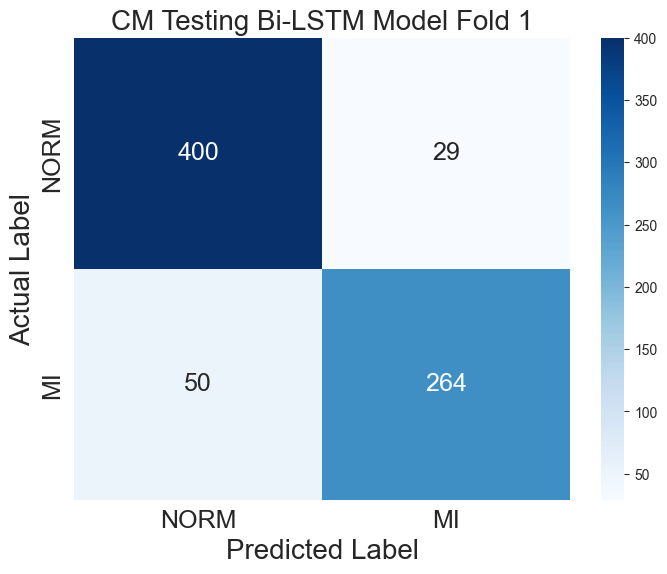


Processing Fold 2



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7846 - loss: 0.4891
Epoch 1: val_accuracy improved from -inf to 0.83770, saving model to modelResult/best_bi_lstm_model_fold_2.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 157s 457ms/step - accuracy: 0.7846 - loss: 0.4891 - val_accuracy: 0.8377 - val_loss: 0.3961 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.8274 - loss: 0.4106
Epoch 2: val_accuracy improved from 0.83770 to 0.83994, saving model to modelResult/best_bi_lstm_model_fold_2.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 153s 457ms/step - accuracy: 0.8274 - loss: 0.4106 - val_accuracy: 0.8399 - val_loss: 0.3879 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8316 - loss: 0.4060
Epoch 3: val_accuracy did not improve from 0.83994
335/335 ━━━━━━━━━━━━━━━━━━━━ 153s 456ms/step - accuracy: 0.8315 - loss: 0.4060 - val_accuracy: 0.8212 - val_loss: 0.3867 - learning_rate: 0.0010
Epoch 4/50
335/335 ━━

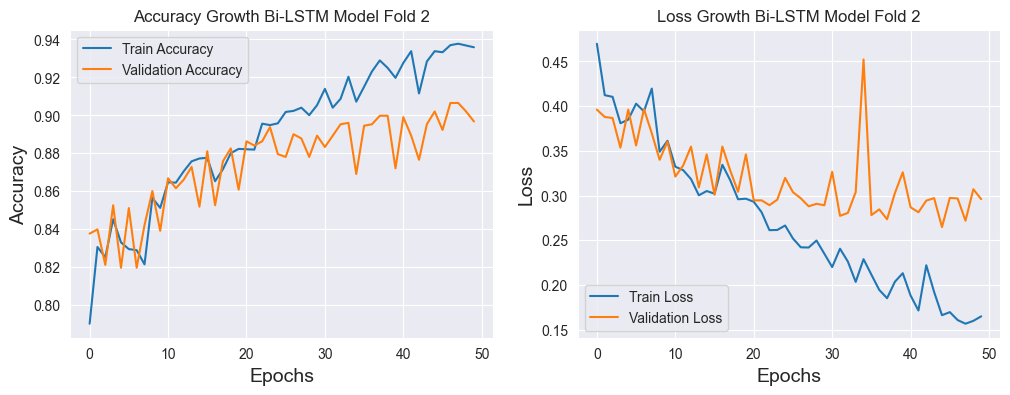

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.8988 - loss: 0.2773
Test Loss: 0.28187131881713867, Test Accuracy: 0.9044414758682251
168/168 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step


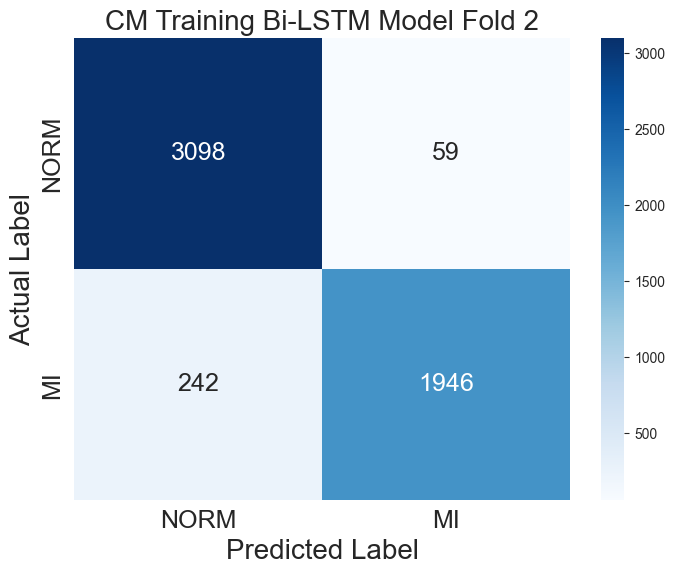

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step


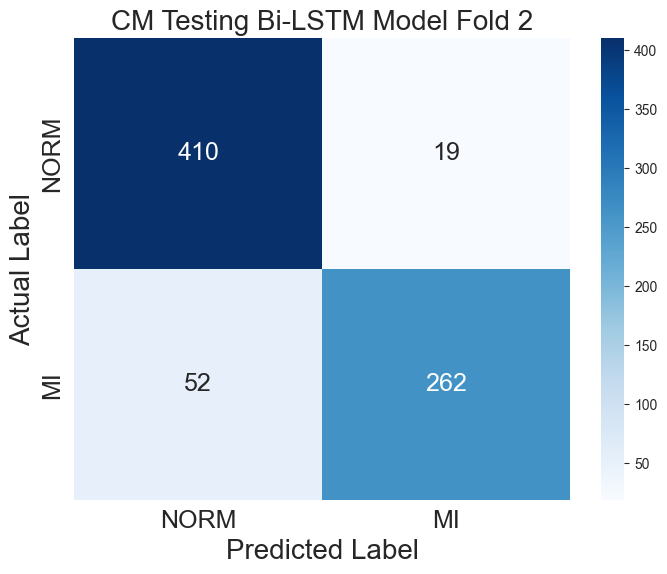


Processing Fold 3



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8182 - loss: 0.4461
Epoch 1: val_accuracy improved from -inf to 0.86602, saving model to modelResult/best_bi_lstm_model_fold_3.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 161s 469ms/step - accuracy: 0.8182 - loss: 0.4460 - val_accuracy: 0.8660 - val_loss: 0.3737 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.8188 - loss: 0.4335
Epoch 2: val_accuracy did not improve from 0.86602
335/335 ━━━━━━━━━━━━━━━━━━━━ 150s 449ms/step - accuracy: 0.8187 - loss: 0.4337 - val_accuracy: 0.7650 - val_loss: 0.4791 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.7869 - loss: 0.4738
Epoch 3: val_accuracy did not improve from 0.86602
335/335 ━━━━━━━━━━━━━━━━━━━━ 150s 448ms/step - accuracy: 0.7869 - loss: 0.4738 - val_accuracy: 0.8263 - val_loss: 0.3976 - learning_rate: 0.0010
Epoch 4/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.8156 - loss: 0.427

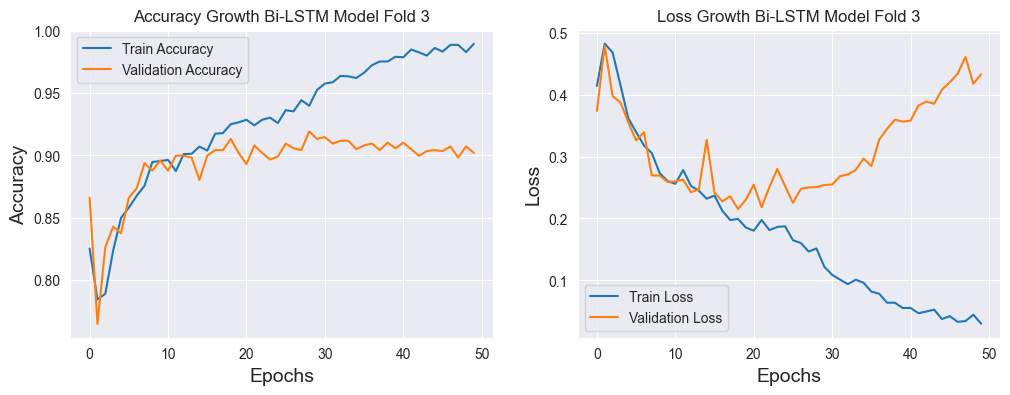

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.9077 - loss: 0.5091
Test Loss: 0.5364328622817993, Test Accuracy: 0.9057873487472534
168/168 ━━━━━━━━━━━━━━━━━━━━ 31s 181ms/step


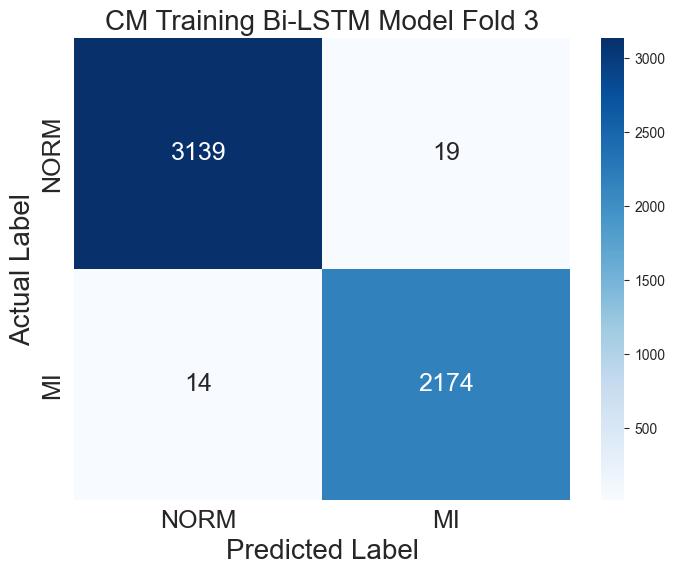

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step


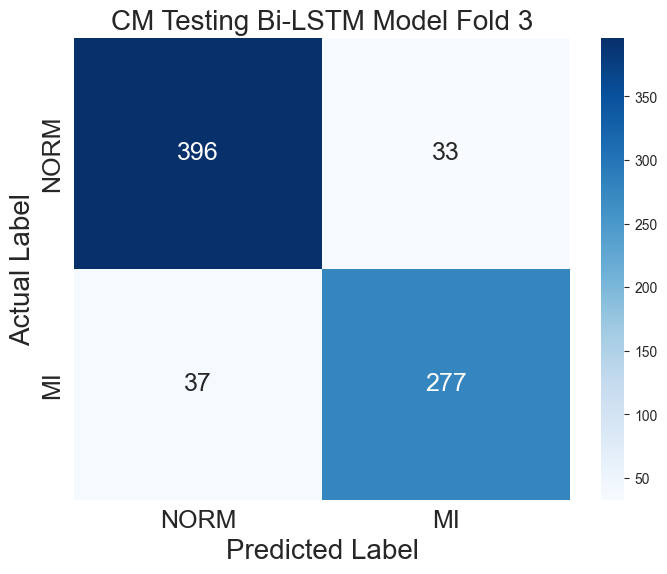


Processing Fold 4



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.8110 - loss: 0.4331
Epoch 1: val_accuracy improved from -inf to 0.83982, saving model to modelResult/best_bi_lstm_model_fold_4.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 160s 466ms/step - accuracy: 0.8110 - loss: 0.4331 - val_accuracy: 0.8398 - val_loss: 0.3949 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.8365 - loss: 0.3880
Epoch 2: val_accuracy improved from 0.83982 to 0.85404, saving model to modelResult/best_bi_lstm_model_fold_4.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 157s 470ms/step - accuracy: 0.8365 - loss: 0.3880 - val_accuracy: 0.8540 - val_loss: 0.3590 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8545 - loss: 0.3586
Epoch 3: val_accuracy did not improve from 0.85404
335/335 ━━━━━━━━━━━━━━━━━━━━ 154s 460ms/step - accuracy: 0.8545 - loss: 0.3586 - val_accuracy: 0.8503 - val_loss: 0.3613 - learning_rate: 0.0010
Epoch 4/50
335/335 ━━

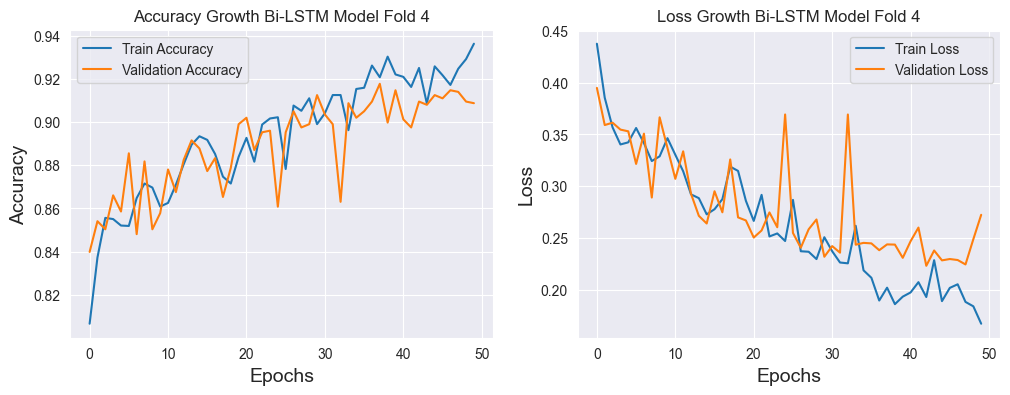

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 0.9028 - loss: 0.2971
Test Loss: 0.31437060236930847, Test Accuracy: 0.9057873487472534
168/168 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step


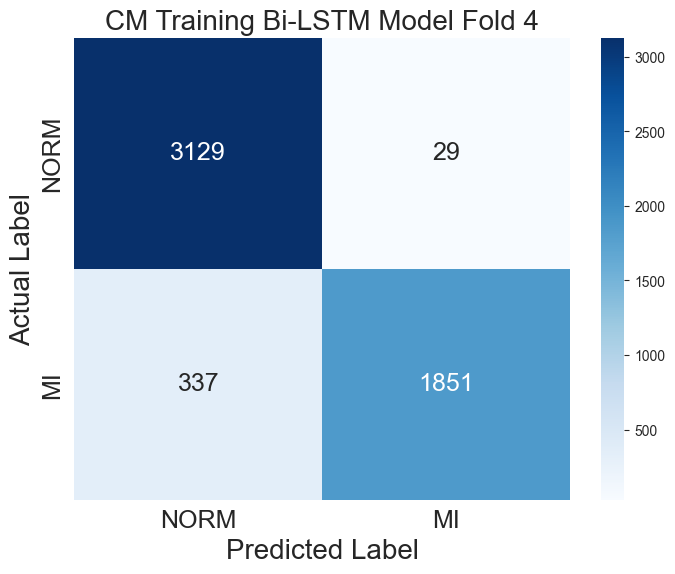

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step


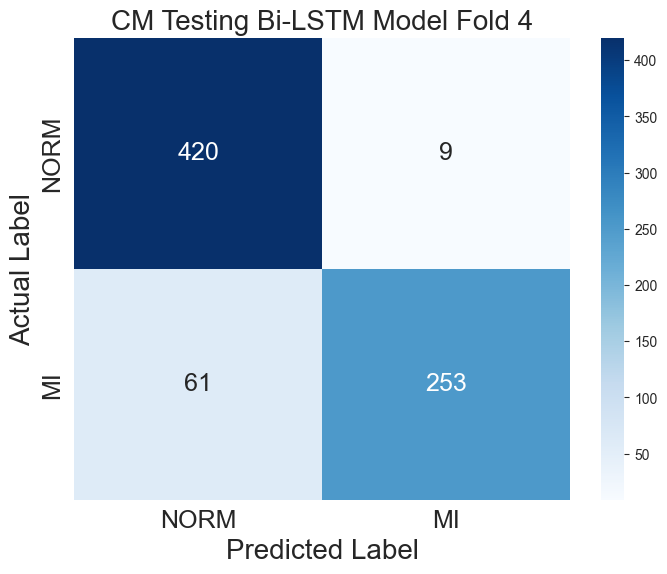


Processing Fold 5



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8157 - loss: 0.4301
Epoch 1: val_accuracy improved from -inf to 0.82485, saving model to modelResult/best_bi_lstm_model_fold_5.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 174s 504ms/step - accuracy: 0.8157 - loss: 0.4300 - val_accuracy: 0.8249 - val_loss: 0.4043 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.8401 - loss: 0.4031
Epoch 2: val_accuracy improved from 0.82485 to 0.85329, saving model to modelResult/best_bi_lstm_model_fold_5.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 168s 501ms/step - accuracy: 0.8402 - loss: 0.4031 - val_accuracy: 0.8533 - val_loss: 0.3662 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.8495 - loss: 0.3674
Epoch 3: val_accuracy did not improve from 0.85329
335/335 ━━━━━━━━━━━━━━━━━━━━ 210s 627ms/step - accuracy: 0.8495 - loss: 0.3674 - val_accuracy: 0.8518 - val_loss: 0.3874 - learning_rate: 0.0010
Epoch 4/50
335/335 ━━

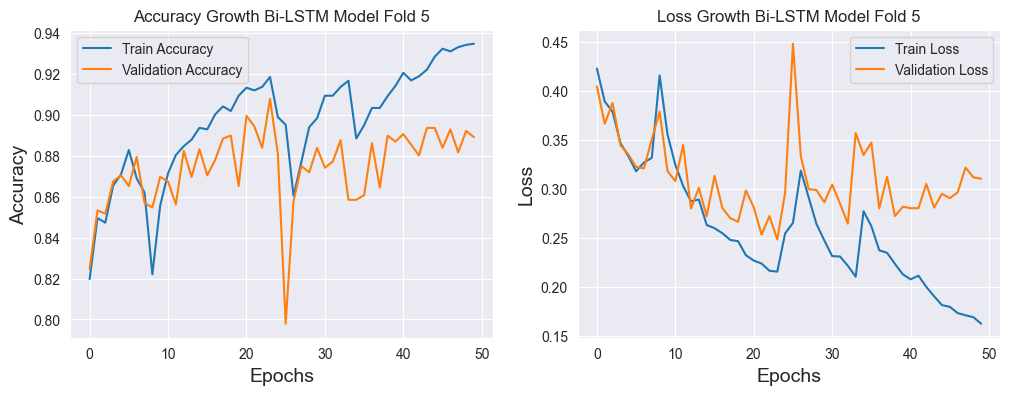

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.9054 - loss: 0.3101
Test Loss: 0.33499929308891296, Test Accuracy: 0.9044414758682251
168/168 ━━━━━━━━━━━━━━━━━━━━ 36s 211ms/step


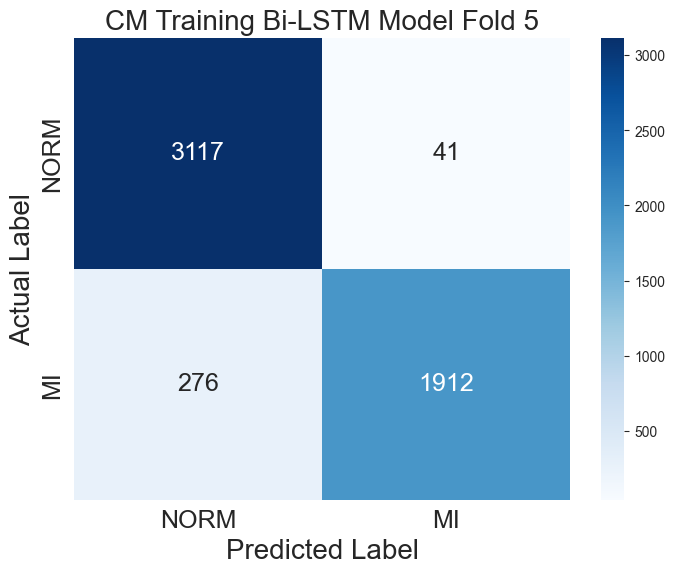

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step


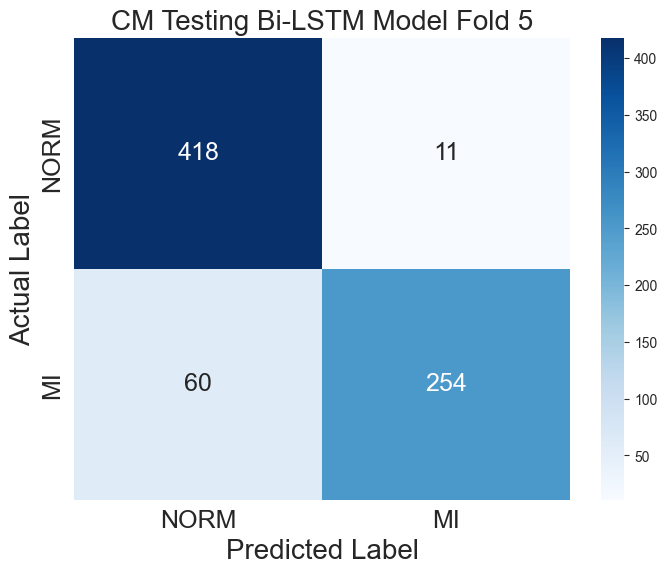


Cross-Validation Metrics Summary:
   fold  test_loss  test_accuracy
0     1   0.341409       0.893674
1     2   0.281871       0.904441
2     3   0.536433       0.905787
3     4   0.314371       0.905787
4     5   0.334999       0.904441

Average Validation Accuracy across all folds: 0.9028


In [26]:
# Placeholder untuk hasil fold
fold_metrics = []

# Step 1: Define Cross-Validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
fold = 0

# Load the pretrained Bi-LSTM model
pretrained_bi_lstm_model = load_model(bi_lstm_model_path)
pretrained_bi_lstm_model.summary()

# Loop untuk setiap fold
for train_index, valid_index in kf.split(X_train, np.argmax(y_train, axis=1)):
    fold += 1
    print(f"\nProcessing Fold {fold}\n")

    # Split the data into training and validation sets for the current fold
    X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
    y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]

    # Load pre-trained model for each fold
    pretrained_bi_lstm_model = load_model(bi_lstm_model_path)

    pretrained_bi_lstm_model.compile(optimizer=Adam(learning_rate=0.001), 
                                     loss='categorical_crossentropy', 
                                     metrics=['accuracy'])
    
    # Step 5: Define Callbacks
    checkpoint = ModelCheckpoint(filepath=f'modelResult/best_bi_lstm_model_fold_{fold}.keras', 
                                 monitor='val_accuracy', 
                                 save_best_only=True, 
                                 verbose=1, 
                                 mode='max')

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.5, 
                                  patience=10, 
                                  min_lr=0.000001, 
                                  verbose=1)

    # Step 6: Fine-tuning the new model on the current fold's training set
    history = pretrained_bi_lstm_model.fit(X_train_fold, y_train_fold, 
                        epochs=50, 
                        batch_size=16, 
                        validation_data=(X_valid_fold, y_valid_fold),
                        callbacks=[checkpoint, reduce_lr], 
                        verbose=1)

    # Step 7: Plot accuracy and loss for the current fold
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy Growth Bi-LSTM Model Fold {fold}')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Growth Bi-LSTM Model Fold {fold}')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()

    plt.savefig(f'image/training_history_bi_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()

    # Step 8: Evaluate model on the test set
    test_loss, test_accuracy = pretrained_bi_lstm_model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    
    # Save fold metrics
    fold_metrics.append({
        "fold": fold,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
    })

    # Step 9: Confusion Matrix on the training set
    y_train_pred = pretrained_bi_lstm_model.predict(X_train_fold)
    y_train_pred_classes = np.argmax(y_train_pred, axis=1)
    y_train_true_classes = np.argmax(y_train_fold, axis=1)
    
    cm_train = confusion_matrix(y_train_true_classes, y_train_pred_classes)
    labels = ['NORM', 'MI']
    
    # Plot training confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title(f'CM Training Bi-LSTM Model Fold {fold}', fontsize=20)
    plt.ylabel('Actual Label', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'image/confusion_matrix_training_bi_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()

    # Save confusion matrix for training as CSV
    cm_train_df = pd.DataFrame(cm_train, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
    cm_train_df.to_csv(f'excel_output/confusion_matrix_training_bi_lstm_model_fold_{fold}.csv')

    # Step 9: Confusion Matrix on the test set
    y_test_pred = pretrained_bi_lstm_model.predict(X_test)
    y_test_pred_classes = np.argmax(y_test_pred, axis=1)
    y_test_true_classes = np.argmax(y_test, axis=1)
    
    cm_test = confusion_matrix(y_test_true_classes, y_test_pred_classes)
    labels = ['NORM', 'MI']
    
    # Plot test confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title(f'CM Testing Bi-LSTM Model Fold {fold}', fontsize=20)
    plt.ylabel('Actual Label', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'image/confusion_matrix_testing_bi_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()

    # Save confusion matrix for testing as CSV
    cm_test_df = pd.DataFrame(cm_test, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
    cm_test_df.to_csv(f'excel_output/confusion_matrix_testing_bi_lstm_model_fold_{fold}.csv')

# Step 10: Save the metrics summary
metrics_df = pd.DataFrame(fold_metrics)
metrics_df.to_csv('excel_output/fold_metrics_summary_bi_lstm_model.csv', index=False)

# Print out the summary of the metrics across all folds
print("\nCross-Validation Metrics Summary:")
print(metrics_df)

# Calculate and print the average accuracy across all folds
mean_accuracy = metrics_df['test_accuracy'].mean()
print(f"\nAverage Validation Accuracy across all folds: {mean_accuracy:.4f}")


# END
